In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.arima_model import ARIMA
from numpy.core.defchararray import add
import math

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
%matplotlib inline

In [4]:
# import os
# os.chdir("/content/drive/My Drive")
# !ls

In [5]:
file_path = "/content/drive/My Drive/MOPAC/Crime/Borough Daily 2018-20.xlsx"

In [6]:
data = pd.read_excel('/content/drive/My Drive/MOPAC/Crime/Borough Daily 2018-20.xlsx')
data2021 = pd.read_excel('/content/drive/My Drive/MOPAC/Crime/Borough Daily Data 2021.xlsx')

df = pd.concat([data, data2021])
data = df
data = data.fillna(data.mean())
data = data.rename(columns={'Date - Daily Data': 'date'})
# data = data.rename(columns={'Month-Year': 'date'})
data = data.groupby(by="date").sum()

df = data["TNO Offs"].to_frame()
df["months"] = np.arange(df.shape[0])
df = df.reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  


In [7]:
df.head()

,TNO Offs,months
0,2098.0,0
1,1973.0,1
2,2353.0,2
3,2234.0,3
4,2224.0,4


In [8]:
df.shape

(1277, 2)

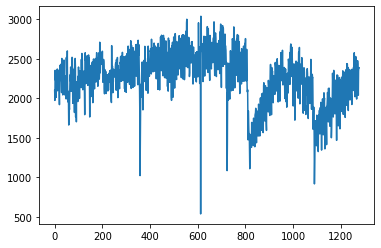

In [9]:
plt.plot(df["TNO Offs"])

In [10]:
X = df["TNO Offs"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -2.836209
p-value: 0.053285
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Failed to Reject Ho - Time Series is Non-Stationary


<center><h1>Auto Regressive Model</h1></center>

$$
Y_{t}=\alpha+\beta_{1} Y_{t-1}+\beta_{2} Y_{t-2}+\ldots+\beta_{p} Y_{t-p}+\epsilon_{1}
$$

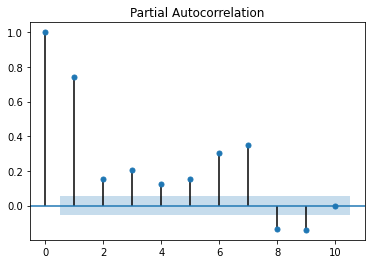

In [11]:
plot_pacf(X, lags=10);

In [12]:
df["Values_shifted"]  = df["TNO Offs"].shift()

In [13]:
df.head()

,TNO Offs,months,Values_shifted
0,2098.0,0,NaN
1,1973.0,1,2098.0
2,2353.0,2,1973.0
3,2234.0,3,2353.0
4,2224.0,4,2234.0


In [14]:
# df.drop('months', axis = 1, inplace=True)

In [15]:
df.dropna(inplace=True)

In [16]:
df.head()

,TNO Offs,months,Values_shifted
1,1973.0,1,2098.0
2,2353.0,2,1973.0
3,2234.0,3,2353.0
4,2224.0,4,2234.0
5,2230.0,5,2224.0


In [17]:
y = df["TNO Offs"].values
X = df.months.values

In [18]:
train_size = int(len(X) * 0.80)
# Use for AR, MA, ARMA models
# X_train, X_test = X[0:train_size], X[train_size:len(X)]
# y_train, y_test = y[0:train_size], y[train_size:len(X)]

# Use for Linear Regression model
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [19]:
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)

In [20]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [21]:
lr.coef_

array([-0.27283481])

In [22]:
lr.intercept_

2462.924996501847

In [23]:
y_pred = lr.predict(X_test)
len(y_pred)

256

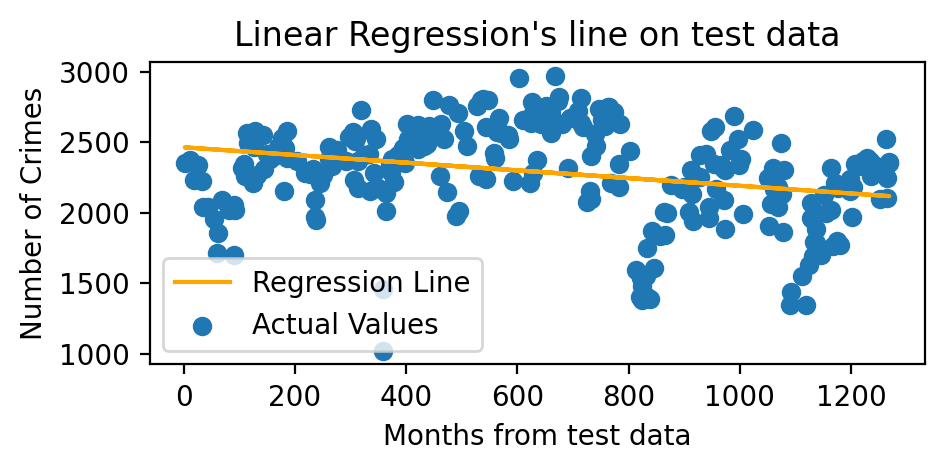

R^2 Score: 5.45%
Test Mean: 2276.69
Test RMSE: 336.06


In [24]:
plt.figure(figsize=(5, 2), dpi=200)
plt.scatter(X_test, y_test, label="Actual Values")
# plt.plot(y_pred, label="Predicted Values")
plt.plot(X_test, (lr.intercept_ + (lr.coef_*X_test)), color="orange", label="Regression Line")
plt.legend()
plt.title("Linear Regression's line on test data")
plt.xlabel("Months from test data")
plt.ylabel("Number of Crimes")
plt.show()
print("R^2 Score: {0:.2%}".format(r2_score(y_test, y_pred)))
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print('Test Mean: %.2f' % y_test.mean())
print('Test RMSE: %.2f' % rmse)

In [25]:
# model = ARIMA(y_train, order=(1,0,0))
from statsmodels.tsa.statespace.sarimax import SARIMAX
model=SARIMAX(y_train,trend='c',order=(2,1,2))

In [26]:
model_fit = model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [27]:
print(model_fit.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 1020
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -7345.499
Date:                Fri, 06 Aug 2021   AIC                          14702.998
Time:                        20:17:08   BIC                          14732.557
Sample:                             0   HQIC                         14714.222
                               - 1020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0640      0.076     -0.839      0.401      -0.214       0.086
ar.L1         -1.0439      0.034    -31.030      0.000      -1.110      -0.978
ar.L2         -0.0464      0.031     -1.478      0.1

In [28]:
# import time
# start = time.process_time()

# train, test = y_train, y_test
# print(test)
# history = [x for x in train]
# print(history)
# predictions = list()
# # walk-forward validation
# for t in range((len(test)+30)):
#   # model = ARIMA(history, order=(1,0,0))
#   model=SARIMAX(history,trend='c',order=(2,1,2))
#   model_fit = model.fit()
#   output = model_fit.forecast()
#   yhat = output[0]
#   predictions.append(yhat)
#   if (t<256):
#     obs = test[t]
#     history.append(obs)
#     print('%i) predicted=%f, expected=%f' % ((t+1), yhat, obs))
#   else:
#     history.append(yhat)
#     print('%i) predicted=%f' % ((t+1), yhat))

# # plot forecasts against actual outcomes
# plt.figure(figsize=(5, 2), dpi=200)
# plt.xlabel("Days from test data")
# plt.ylabel("Number of Crimes")
# plt.plot(test[0:256])
# plt.plot(predictions, color='red')
# plt.show()

# print("R^2 Score: {0:.2%}".format(r2_score(test, predictions[0:256])))
# rmse = math.sqrt(mean_squared_error(test, predictions[0:256]))
# print('Test Mean: %.2f' % test.mean())
# print('Test RMSE: %.2f' % rmse)

# print("Time taken: ", (time.process_time() - start))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


[2175. 2653. 1481. 2576. 2370. 2506. 2012. 2338. 2408. 2043. 1401. 2622.
 2235. 2444. 2127. 2330. 1700. 2167. 2411. 2955. 2171. 2502. 2669. 2316.
 2645. 2612. 2335. 2283. 2674. 2072. 2305. 2464. 2019. 1401. 2438. 2758.
 2336. 2735. 2213. 2133. 2261. 2707. 2358. 1343. 2366. 1378. 2331. 2414.
 2629. 2708. 1763. 2463. 2153. 1537. 2217. 2270. 2307. 2747. 2387. 2250.
 1788. 2017. 2101. 1548. 2593. 2473. 2485. 2363. 2544. 1593. 1715. 2222.
 2316. 2138. 2523. 2453. 2353. 1460. 2582. 2521. 2043. 2415. 2000. 1873.
 2280. 2069. 2412. 2576. 2041. 2132. 2655. 2524. 1795. 2607. 2798. 2369.
 2190. 2402. 2273. 1344. 2564. 2379. 2245. 1386. 2308. 2153. 2315. 1802.
 2692. 2794. 2042. 2092. 2365. 2208. 2406. 2365. 2384. 2232. 2800. 2209.
 1887. 2548. 2247. 1435. 2152. 2348. 2445. 2762. 2785. 2464. 2473. 2372.
 2819. 2262. 2226. 2574. 2495. 2390. 2522. 2800. 2567. 2381. 2555. 2751.
 2629. 1833. 2378. 2268. 1543. 1954. 1630. 1946. 2184. 2196. 2580. 1857.
 2460. 2303. 2523. 2576. 1885. 2017. 1021. 2350. 26

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1) predicted=2315.674875, expected=2175.000000
2) predicted=2278.346264, expected=2653.000000
3) predicted=2256.912304, expected=1481.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4) predicted=2310.608213, expected=2576.000000
5) predicted=2256.779125, expected=2370.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


6) predicted=2268.223444, expected=2506.000000
7) predicted=2262.011471, expected=2012.000000
8) predicted=2285.866679, expected=2338.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


9) predicted=2259.218111, expected=2408.000000
10) predicted=2278.630737, expected=2043.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


11) predicted=2274.163368, expected=1401.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


12) predicted=2324.170271, expected=2622.000000
13) predicted=2232.892941, expected=2235.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


14) predicted=2302.297953, expected=2444.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


15) predicted=2238.351866, expected=2127.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


16) predicted=2302.643813, expected=2330.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


17) predicted=2267.302377, expected=1700.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


18) predicted=2329.406487, expected=2167.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


19) predicted=2234.987826, expected=2411.000000
20) predicted=2290.046395, expected=2955.000000
21) predicted=2215.543845, expected=2171.000000
22) predicted=2311.969047, expected=2502.000000
23) predicted=2224.761572, expected=2669.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


24) predicted=2290.461748, expected=2316.000000
25) predicted=2247.925857, expected=2645.000000
26) predicted=2278.209714, expected=2612.000000
27) predicted=2249.901329, expected=2335.000000
28) predicted=2290.205019, expected=2283.000000
29) predicted=2261.667766, expected=2674.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


30) predicted=2271.759083, expected=2072.000000
31) predicted=2284.214580, expected=2305.000000
32) predicted=2271.991697, expected=2464.000000
33) predicted=2272.153690, expected=2019.000000
34) predicted=2289.490370, expected=1401.000000
35) predicted=2304.223011, expected=2438.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


36) predicted=2252.236250, expected=2758.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


37) predicted=2247.839122, expected=2336.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


38) predicted=2280.560455, expected=2735.000000
39) predicted=2261.213283, expected=2213.000000
40) predicted=2286.152902, expected=2133.000000
41) predicted=2275.550680, expected=2261.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


42) predicted=2280.241366, expected=2707.000000
43) predicted=2256.018853, expected=2358.000000
44) predicted=2286.773060, expected=1343.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


45) predicted=2306.829527, expected=2366.000000
46) predicted=2259.555733, expected=1378.000000
47) predicted=2324.594187, expected=2331.000000
48) predicted=2238.298852, expected=2414.000000
49) predicted=2265.280665, expected=2629.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


50) predicted=2233.728184, expected=2708.000000
51) predicted=2283.404631, expected=1763.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


52) predicted=2305.313096, expected=2463.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


53) predicted=2256.758423, expected=2153.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


54) predicted=2288.351730, expected=1537.000000
55) predicted=2306.448500, expected=2217.000000
56) predicted=2261.820856, expected=2270.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


57) predicted=2265.770154, expected=2307.000000


KeyboardInterrupt: ignored

In [ ]:
plt.figure(figsize=(5, 2), dpi=200)
plt.xlabel("Days from test data")
plt.ylabel("Number of Crimes")
plt.plot(predictions[-30:], color='red')